# Gold Recovery Rate from Gold-Bearing Ore

Here's a translation of your request:

Prepare a prototype of a machine learning model for "Digits". The company develops solutions for efficient operation of industrial enterprises.

The model should predict the gold recovery rate from gold-bearing ore. You have data with mining and refining parameters at your disposal.

The model will help optimize production to avoid launching a facility with unprofitable characteristics.

You need to:
1. Prepare the data;
2. Conduct exploratory data analysis;
3. Build and train the model.

## Data Preparation

### Open the files and examine them

In [25]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler


METALS = ['au', 'ag', 'pb']
CONCENTRATE_METRICS = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
RANDOM_STATE = 12345
TARGETS = ['rougher.output.recovery', 'final.output.recovery']

In [26]:
train_df = pd.read_csv('./datasets/gold_recovery_train_new.csv')
test_df = pd.read_csv('./datasets/gold_recovery_test_new.csv')
full_df = pd.read_csv('./datasets/gold_recovery_full_new.csv')

In [27]:
data = [train_df, test_df, full_df]
data_names = ['Training Set', 'Test Set', 'Full Data']

def percent_of_missing_values(df):
    number_of_missing = df.isnull().sum()
    missing_value_df = pd.DataFrame({
        'number_of_missing': number_of_missing,
        'percent_of_missing': round((number_of_missing / len(df)) * 100, 2)
    })
    return missing_value_df[missing_value_df['number_of_missing'] > 0]

for df, name in zip(data, data_names):
    print(name, '-', 'General column information:', end='\n\n')
    display(df.info())
    print(f'{name} - Number of duplicates: {df.duplicated().sum()}', end='\n\n')
    print(name, '-', 'Percentage of missing values in columns:', end='\n')
    display(percent_of_missing_values(df).sort_values('percent_of_missing', ascending=False))

Training Set - General column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol           

None

Training Set - Number of duplicates: 0

Training Set - Percentage of missing values in columns:


,number_of_missing,percent_of_missing
secondary_cleaner.output.tail_sol,1605,11.34
rougher.state.floatbank10_e_air,436,3.08
rougher.input.floatbank11_xanthate,428,3.02
primary_cleaner.output.concentrate_sol,286,2.02
secondary_cleaner.state.floatbank2_a_air,217,1.53
...,...,...
rougher.state.floatbank10_a_level,1,0.01
rougher.state.floatbank10_b_air,1,0.01
rougher.state.floatbank10_b_level,1,0.01
rougher.state.floatbank10_c_air,1,0.01


Test Set - General column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5

None

Test Set - Number of duplicates: 0

Test Set - Percentage of missing values in columns:


,number_of_missing,percent_of_missing
rougher.input.floatbank11_xanthate,25,0.47
rougher.input.feed_sol,21,0.40
secondary_cleaner.state.floatbank3_a_air,9,0.17
rougher.input.floatbank11_sulfate,8,0.15
primary_cleaner.input.depressant,5,0.09
rougher.input.floatbank10_sulfate,5,0.09
primary_cleaner.input.sulfate,4,0.08
primary_cleaner.input.xanthate,4,0.08
rougher.input.feed_rate,3,0.06
secondary_cleaner.state.floatbank2_a_air,3,0.06


Full Data - General column information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol              

None

Full Data - Number of duplicates: 0

Full Data - Percentage of missing values in columns:


,number_of_missing,percent_of_missing
secondary_cleaner.output.tail_sol,1748,8.99
rougher.input.floatbank11_xanthate,453,2.33
rougher.state.floatbank10_e_air,436,2.24
primary_cleaner.output.concentrate_sol,370,1.90
secondary_cleaner.state.floatbank2_a_air,220,1.13
...,...,...
rougher.state.floatbank10_a_level,1,0.01
rougher.state.floatbank10_b_air,1,0.01
rougher.state.floatbank10_b_level,1,0.01
rougher.state.floatbank10_c_air,1,0.01


**Conclusion**

In the training set, there are 87 columns and 14,149 objects. The data types in the columns correspond to their nature, except for the `date` column. There are missing values in 62 columns, with the most in the `secondary_cleaner.output.tail_sol` column - 11%, indicating a lack of data on the amount of salts in the tailings after the second stage of purification. Missing values in other columns are less than 3%. There are no duplicates in the table.

In the test set, there are 53 columns and 5,290 objects. The data type in the `date` column is incorrect. There are missing values in 12 columns, but their percentage is less than 0.5%. There are no duplicates in the table.

In the full dataset, there are 87 columns and 19,439 objects (which is correct and equals the sum of the number of objects in the training and test sets). The data type in the `date` column also does not correspond to the activity. There are no duplicates in the table. There are missing values in 63 columns. Interestingly, the quantity of missing values in the full dataset is greater than the sum of the missing values in the two sets. This suggests that the data in the sets may already be somehow processed or filled in.

We will revisit these conclusions during the data preprocessing stage.

### Calculating the Recovery Efficiency

Let's verify that the recovery efficiency is calculated correctly by computing it on the training set for the feature `rougher.output.recovery`.

\begin{align}
Recovery = \frac{C(F - T)} {F(C - T)} * 100%
\end{align}

For `rougher.output.recovery`:
- C - `rougher.output.concentrate_au`
- F - `rougher.input.feed_au`
- T - `rougher.output.tail_au`

This formula calculates the recovery efficiency of gold from gold-bearing ore in the rougher flotation stage.

In [28]:
def get_rougher_recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    return ((c * (f - t)) / (f * (c - t))) * 100

rougher_recovery_calc = train_df.apply(get_rougher_recovery, axis = 1)

Let's find the Mean Absolute Error (MAE) between our calculations and the actual values of the feature.

In [29]:
print(f"MAE equal to {mean_absolute_error(train_df['rougher.output.recovery'], rougher_recovery_calc)}")

MAE equal to 9.73512347450521e-15


**Conclusion**
The Mean Absolute Error is almost equal to zero, indicating that the recovery efficiency is calculated correctly.

### Features not available in the test set

In [30]:
train_cols = train_df.columns
test_cols = test_df.columns

print([col for col in train_cols if col not in test_cols])

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

But we will add target indicators to the test dataset.

In [31]:
test_df = test_df.merge(full_df[[*TARGETS, 'date']], on='date', how='left')

**Conclusion**
In the test set, we have 35 features unavailable to us. They are all online metrics that we can only obtain during the operation of the system (i.e., after the (`output`) stages such as rougher flotation and cleaning (primary_cleaner, secondary_cleaner), before the (`input`) first and second cleaning stages (primary_cleaner, secondary_cleaner), and at the end (`final`)). Our model won't be able to use these features for prediction, but for now, we'll leave these columns in the table for data analysis purposes.

### Data Preprocessing
Since we know that the original dataset contains more missing values, we will only use the data from the training and test sets in the future and preprocess only these datasets.

**Data Type Conversion**

In [32]:
data = [train_df, test_df]

date_format = '%Y-%m-%d %H:%M:%S'
for df in data:
    df['date'] = pd.to_datetime(df['date'], format=date_format)

**Handling Missing Values**

We know that parameters close in time are often similar, so to fill in missing values in row k, we will use data from row k-1.

In [33]:
for df in data:
    df.fillna(method='ffill', inplace=True)

/var/folders/9c/dh3yhrb55296prf50tbgxdk80000gn/T/ipykernel_70878/3226609395.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## Data Analysis

### Concentration of metals (Au, Ag, Pb) at various stages of purification

Let's see how the concentration of metals (Au, Ag, Pb) changes at different stages of purification.

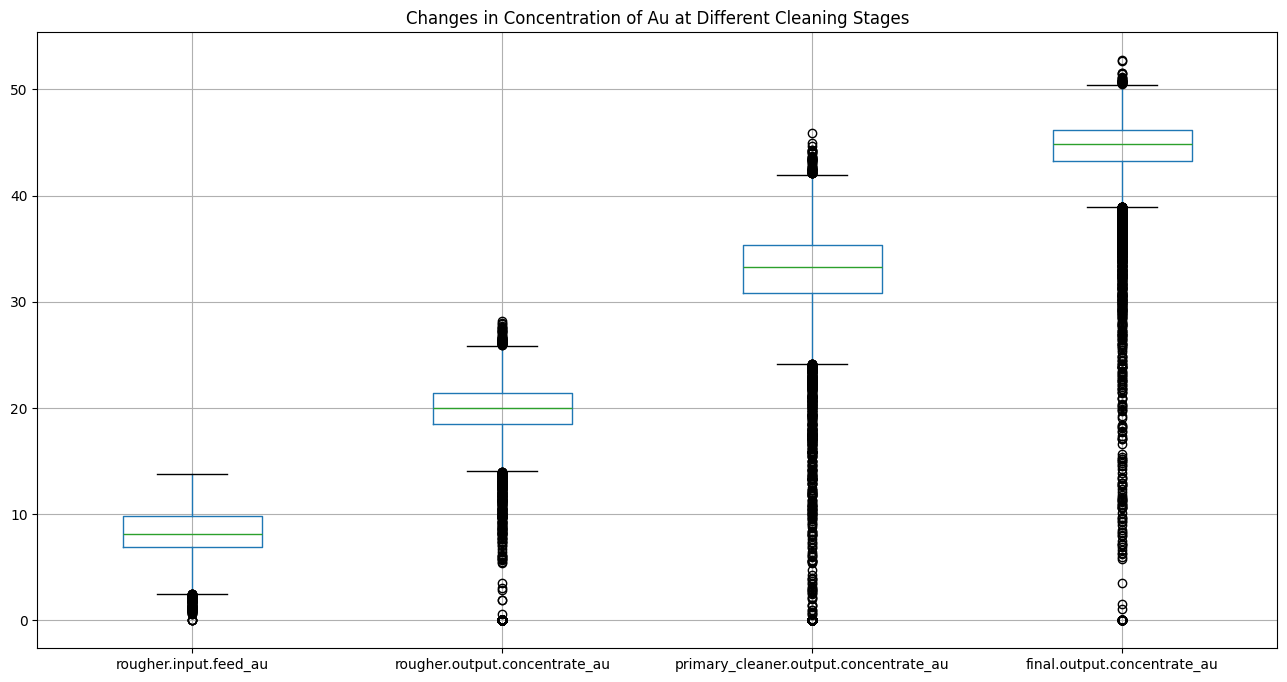

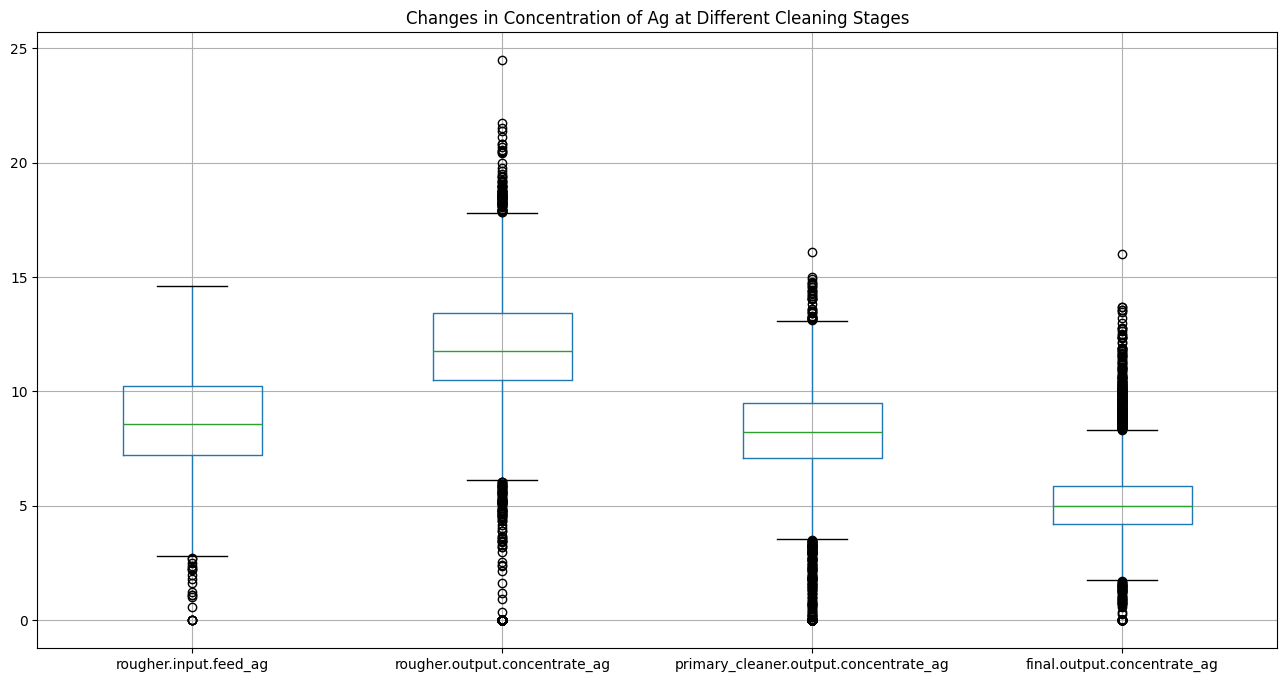

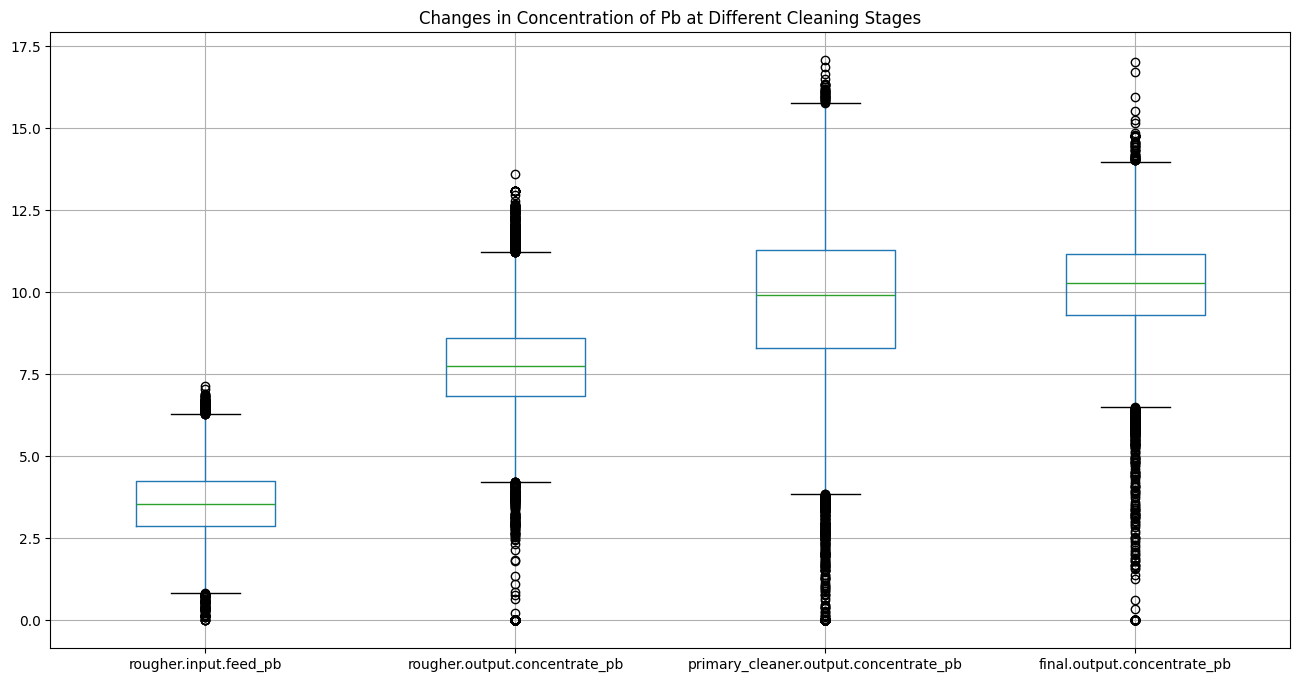

In [34]:
full_data = pd.concat([train_df, test_df])

for metal in METALS:
    metrics = [f'{metric}_{metal}' for metric in CONCENTRATE_METRICS]
    full_data[metrics].boxplot(figsize=(16, 8))
    plt.title(f'Changes in Concentration of {metal.capitalize()} at Different Cleaning Stages')
    plt.show()

**Conclusion**

- The concentration of gold increases with each new stage of purification, which is logical since the goal of flotation and cleaning is to increase the concentration of gold.
- The concentration of silver, although it increases after flotation, reaches its minimum median at the final stage. There is a noticeable reduction in the range of values.
- The concentration of lead also increases, like gold. However, after primary cleaning, we can observe a large dispersion of values.

### Distribution of Raw Ore Particle Sizes

Let's compare the distributions of raw ore particle sizes in the training and test sets. If the distributions differ significantly from each other, the model evaluation will be incorrect.

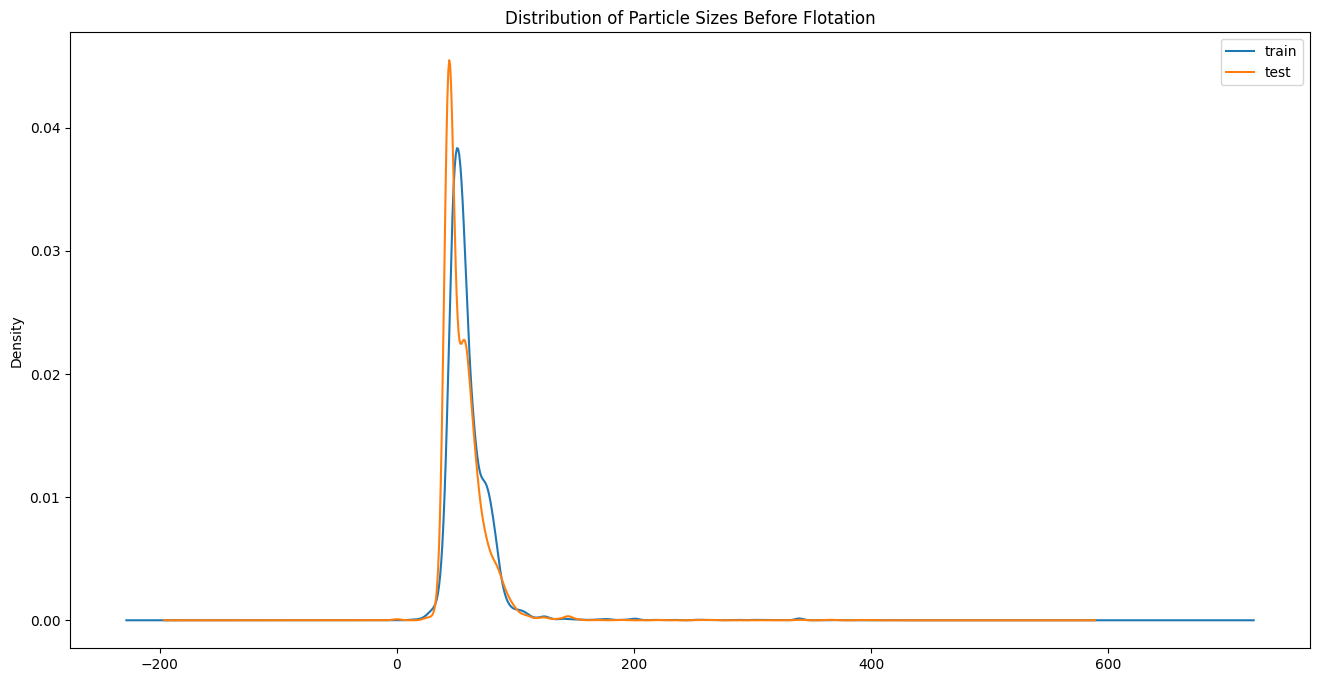

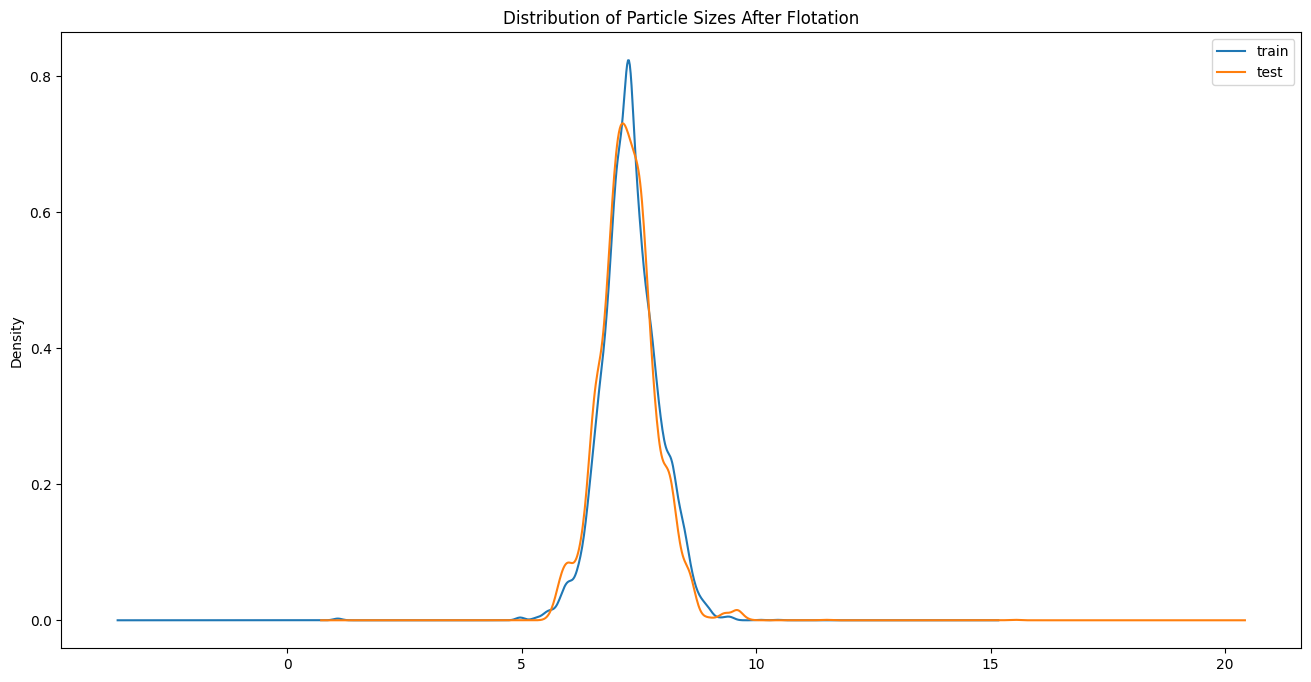

In [35]:
cols = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

for col, title in zip(cols, ['Before Flotation', 'After Flotation']):
    for df, name in zip(data, ['train', 'test']):
        df[col].plot(kind='kde', figsize=(16, 8), label=name, legend=True)
    plt.title(f'Distribution of Particle Sizes {title}')
    plt.show()

**Conclusion**

The distribution of particle sizes before flotation in the training and test sets is similar to each other and resembles a left-skewed normal distribution.

Particle sizes after flotation are normally distributed for both the training and test sets.

### Total Concentration of All Substances

Let's investigate the total concentration of all substances at different stages: in the feed, in the rougher concentrate, and in the final concentrate.

In [36]:
for metric in CONCENTRATE_METRICS:
    train_df[metric] = 0
    for metal in METALS + ['sol']:
        train_df[metric] += train_df[f'{metric}_{metal}']

train_df[CONCENTRATE_METRICS].plot(kind='hist', alpha=0.5, figsize=(16, 8), bins=100, title='Histogram of Concentration Distribution at Different Cleaning Stages')

<Axes: title={'center': 'Histogram of Concentration Distribution at Different Cleaning Stages'}, ylabel='Frequency'>

In the data, there are numerous outliers: the distributions are heavily skewed to the left, and we also observe many zero values.

Let's plot histograms and boxplots for each feature. After that, we'll get rid of the anomalous values by determining the boundaries of the normal distribution (i.e., Q1 - 1.5*IQR and Q3 + 1.5*IQR). Then, we'll reexamine the distribution diagram for each feature to see how it has changed.

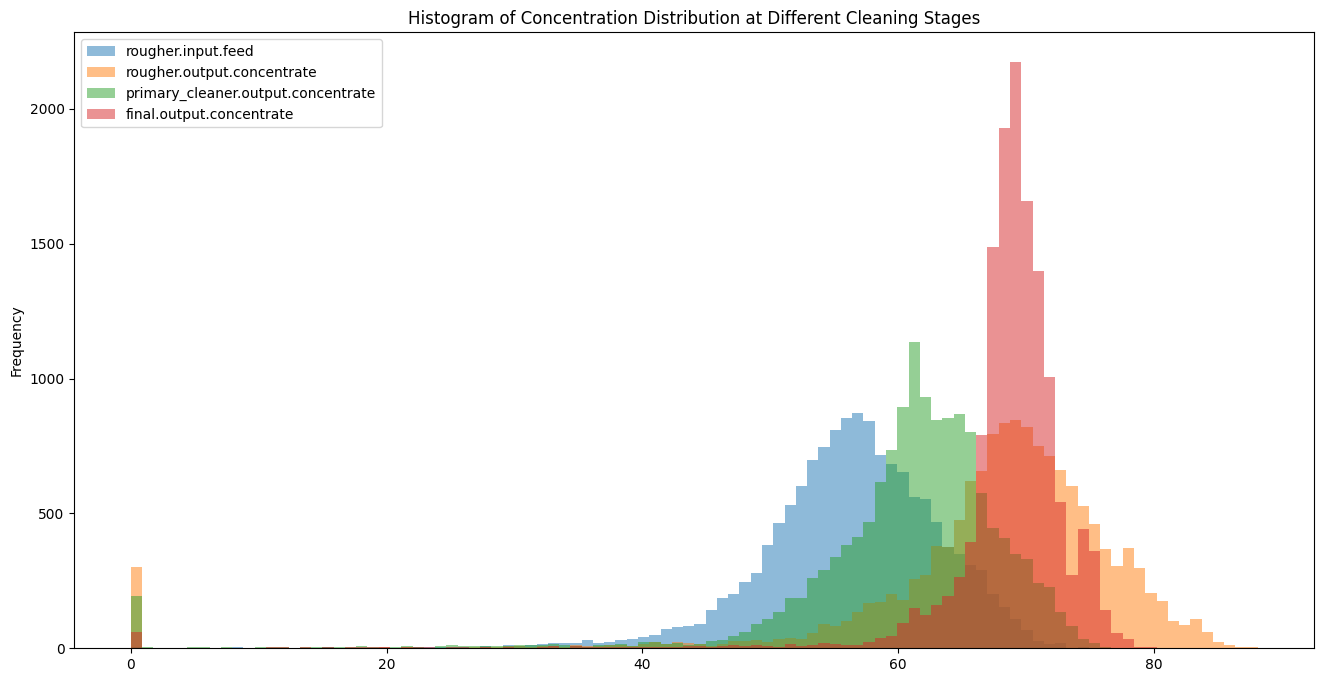

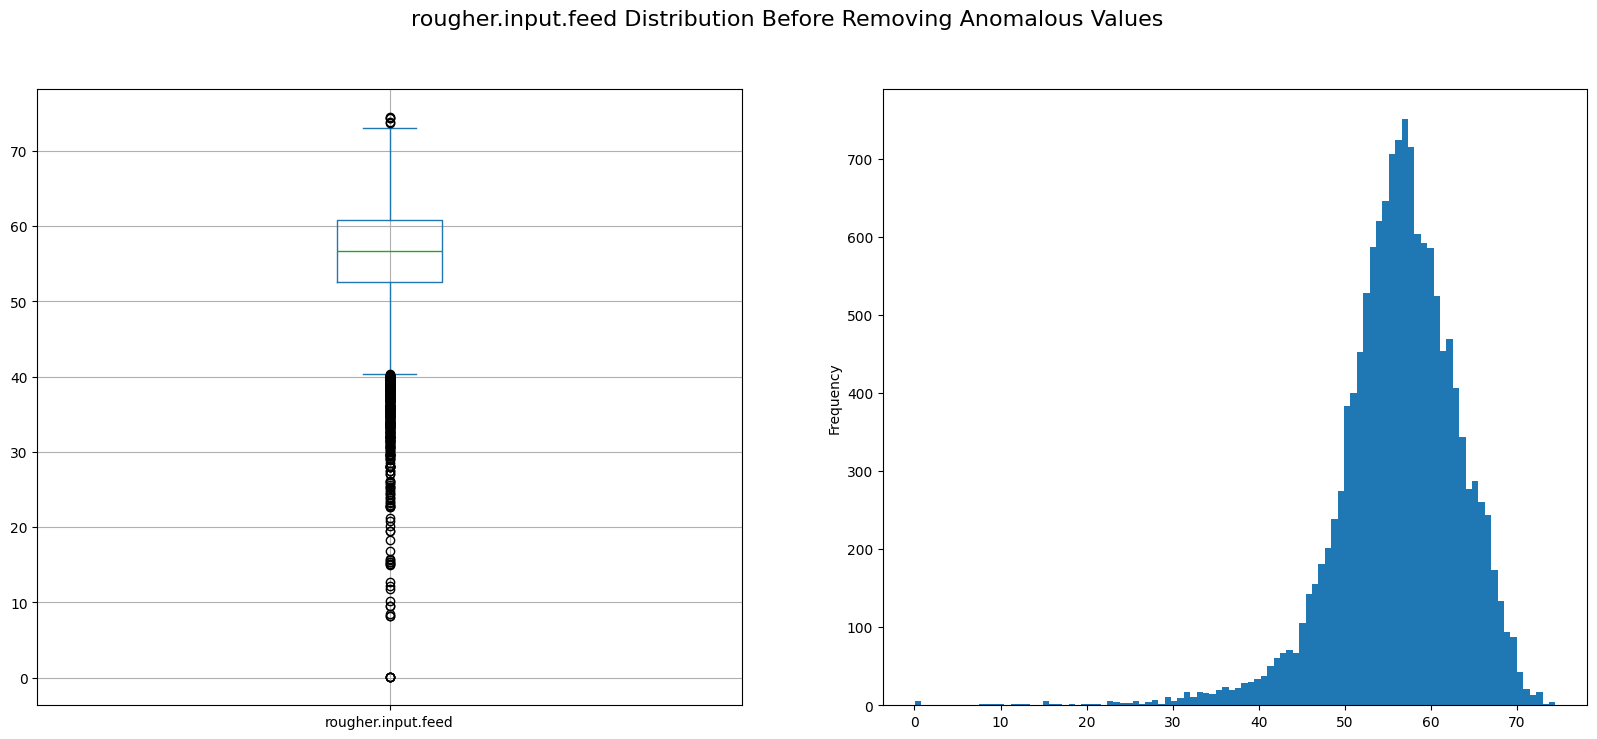

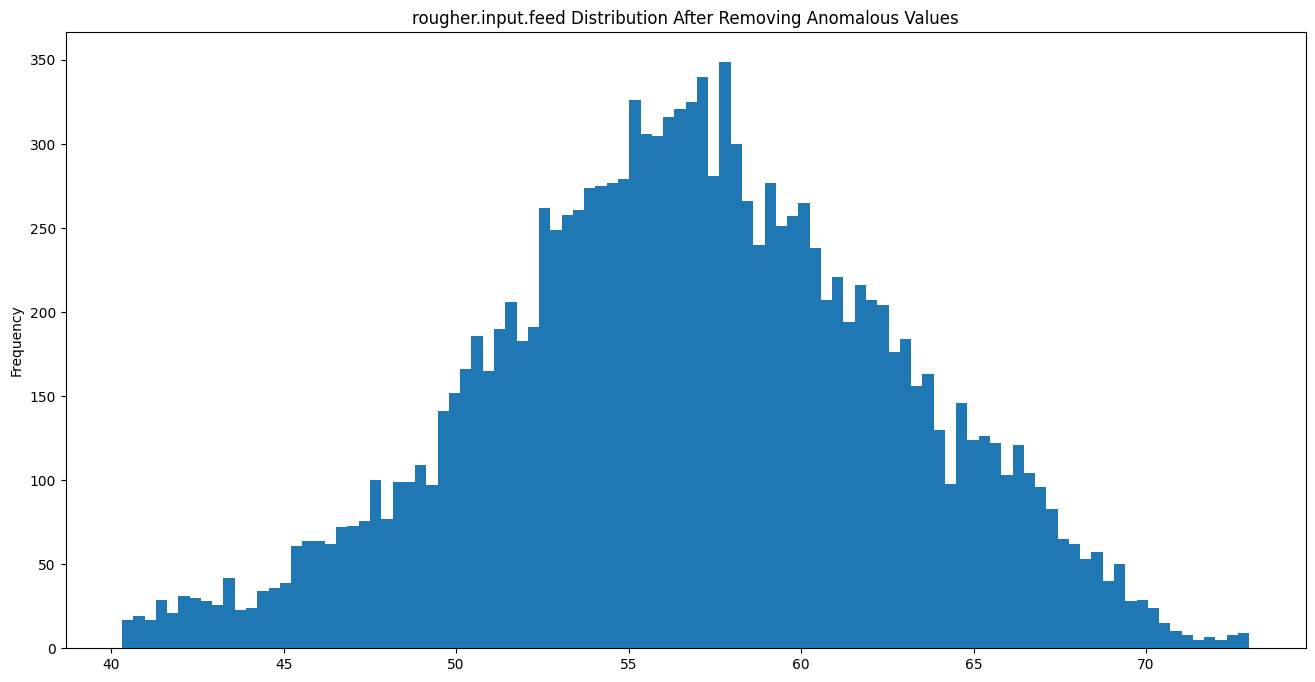

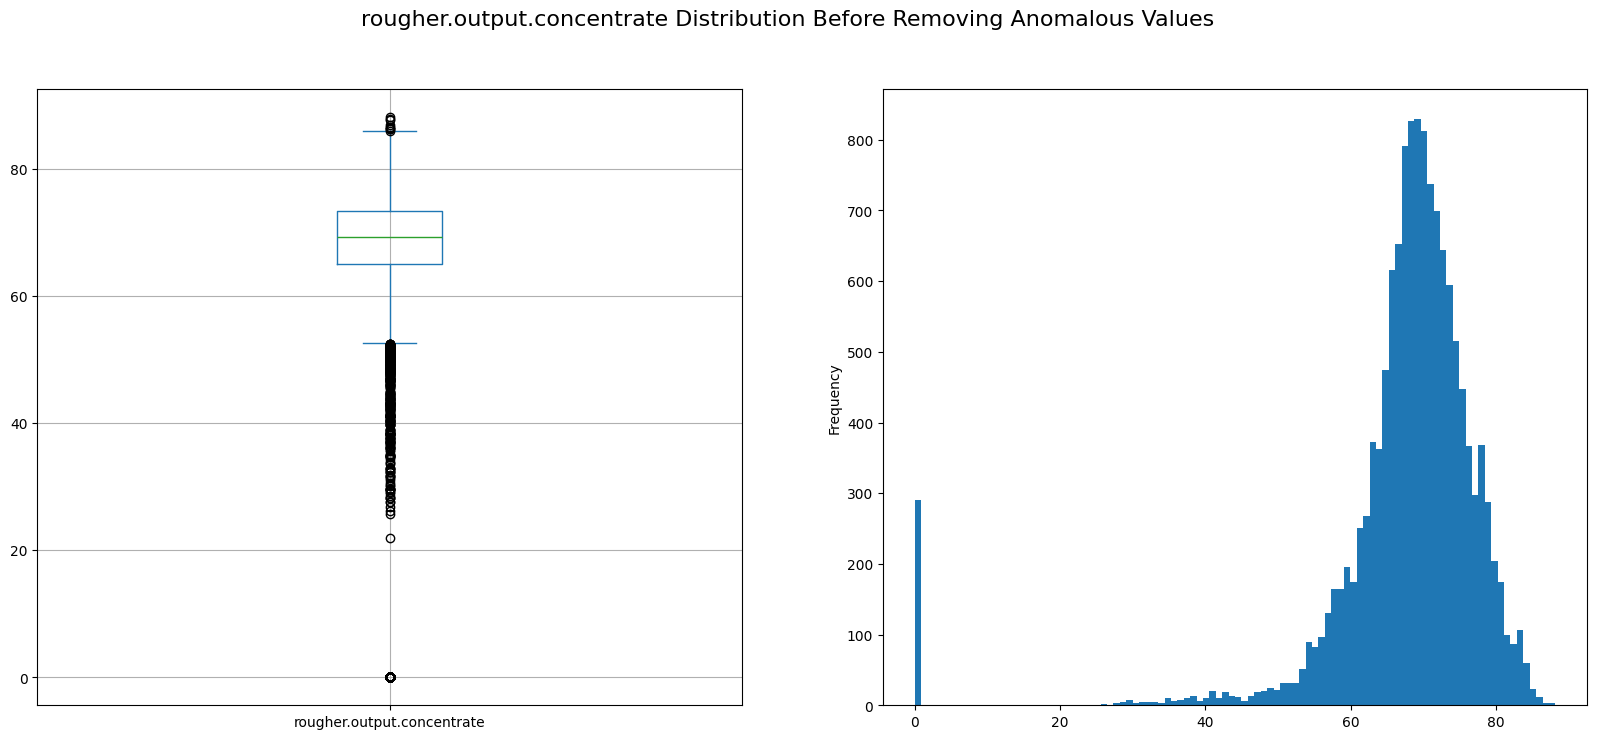

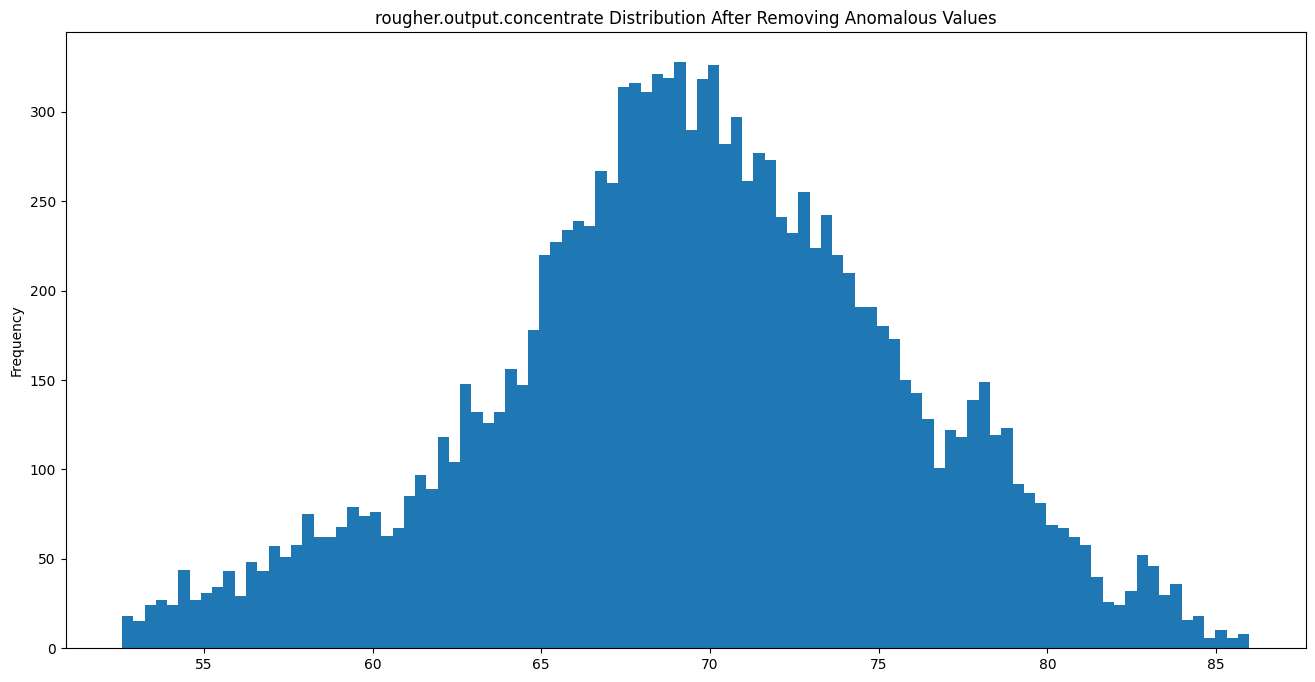

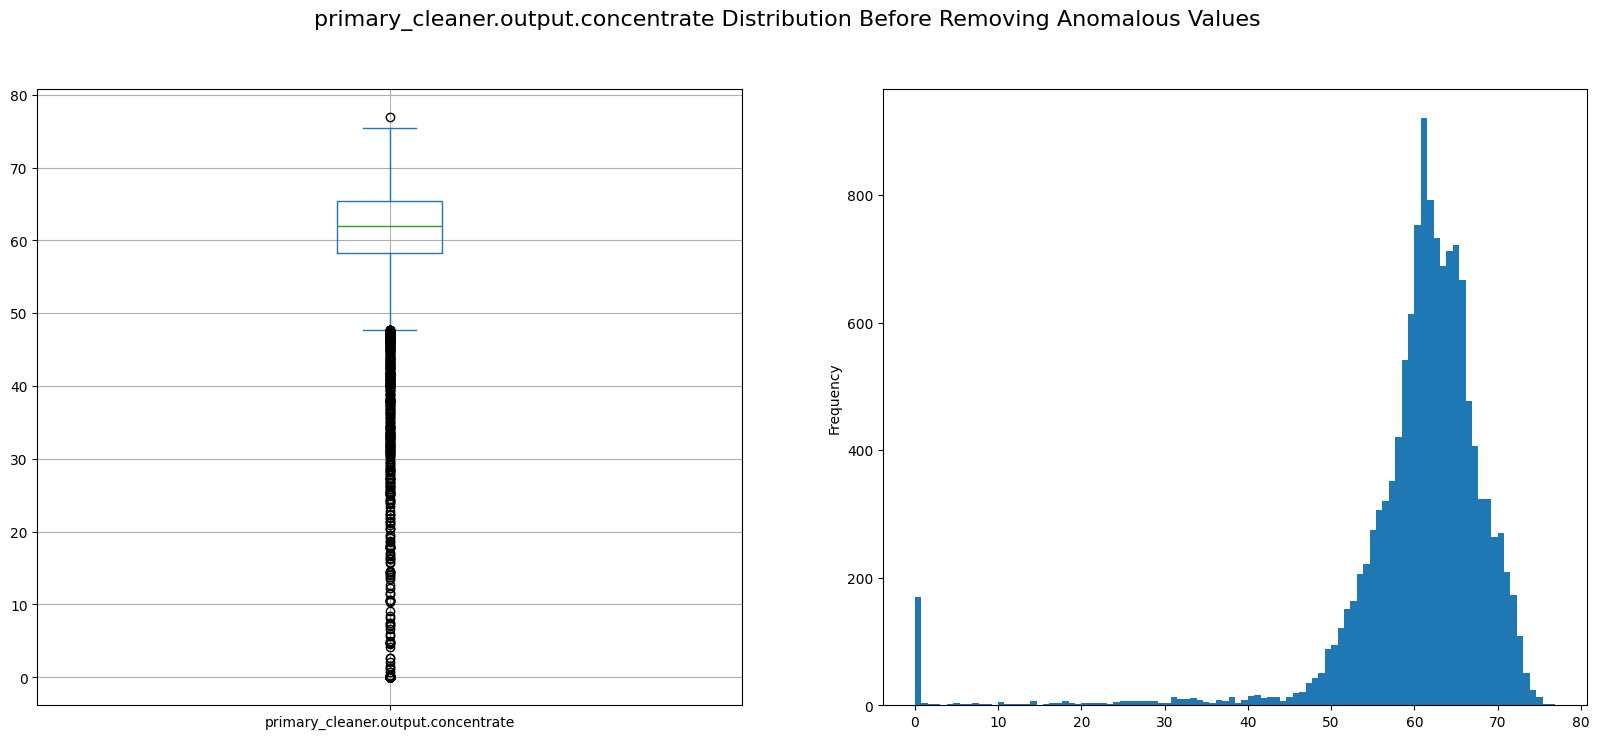

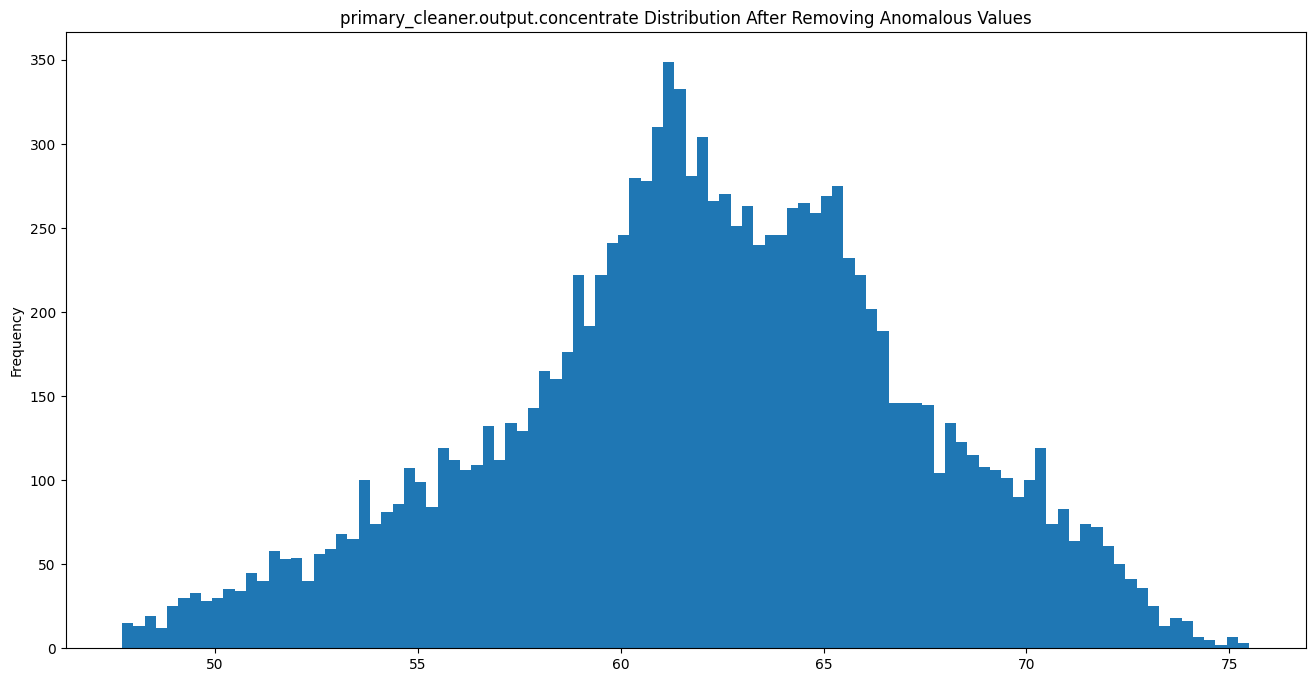

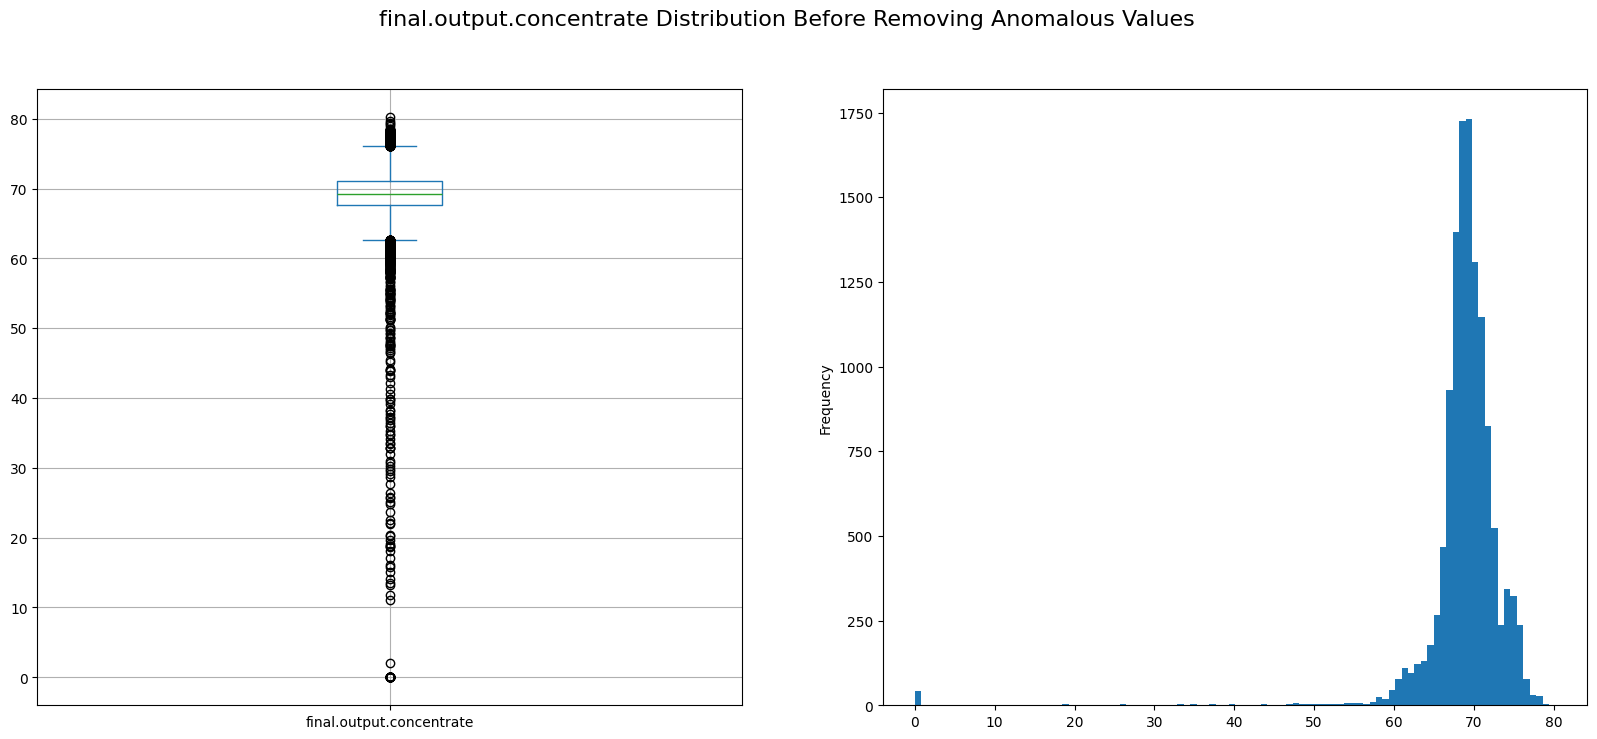

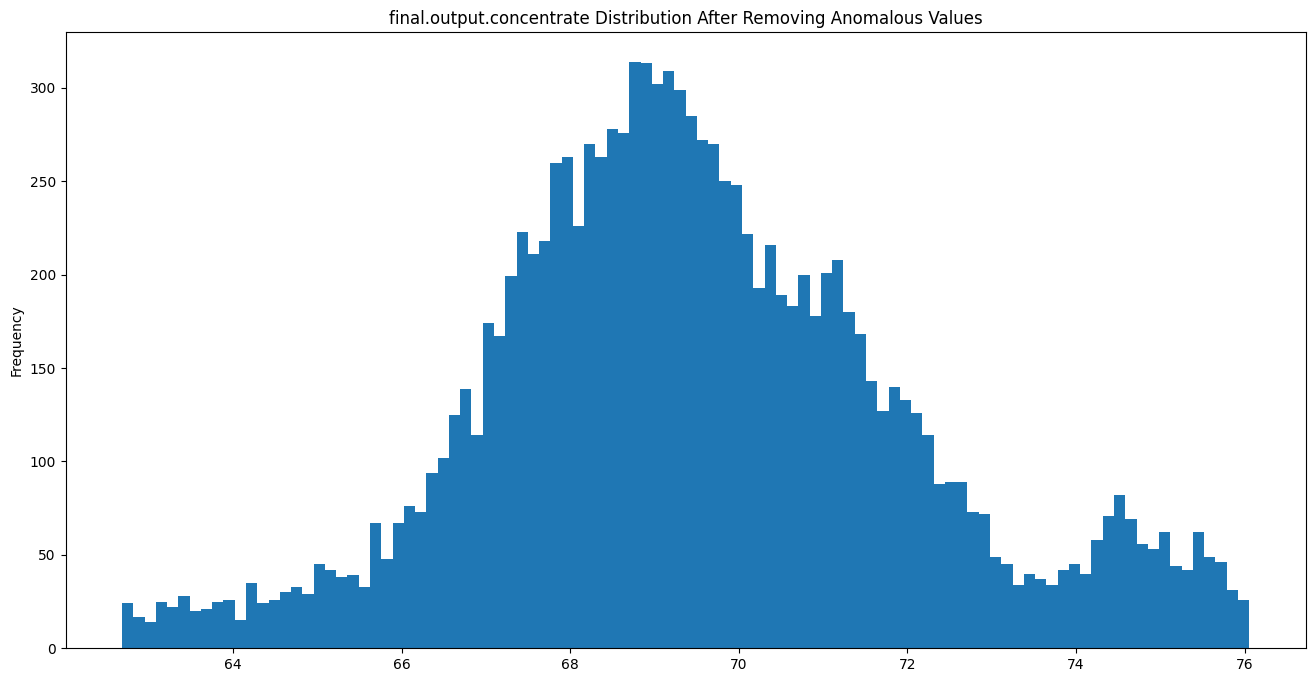

In [37]:
def get_whiskers(dataset):
    q_1 = dataset.quantile(0.25)
    q_3 = dataset.quantile(0.75)
    iqr = q_3 - q_1
    left_whisker = q_1 - 1.5 * iqr
    right_whisker = q_3 + 1.5 * iqr
    return (
        max(dataset.min(), left_whisker),
        min(dataset.max(), right_whisker)
    )

for metric in CONCENTRATE_METRICS:
    dataset = train_df[metric]
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    dataset.plot(kind='box', grid=True, ax=axes[0])
    dataset.plot(kind='hist', bins=100, ax=axes[1])
    fig.suptitle(f'{metric} Distribution Before Removing Anomalous Values', fontsize=16)
    plt.show()
    l_whisker, r_whisker = get_whiskers(dataset)
    train_df = train_df[(dataset > l_whisker) &  (dataset < r_whisker)]
    train_df[metric].plot(kind='hist', bins=100, figsize=(16,8), title=f'{metric} Distribution After Removing Anomalous Values')
    plt.show()

**Conclusion**

After removing anomalous values, the distribution became symmetrical. We will not remove outliers in the test set because they cannot affect the adequacy of our model in any way.

## Model Building

### Function for Calculating Overall sMAPE

Let's write a function to calculate the overall sMAPE.

In [38]:
def smape(target, predictions):
    numerator = np.abs(target - predictions)
    denominator = (np.abs(target) + np.abs(predictions)) / 2
    return 1 / len(target) * np.sum(numerator / denominator) * 100

def final_smape(target, predictions):
    target_rougher = target['rougher.output.recovery']
    target_final = target['final.output.recovery']

    predictions_rougher = predictions[:, 0]
    predictions_final = predictions[:, 1]

    smape_rougher = smape(target_rougher, predictions_rougher)
    smape_final = smape(target_final, predictions_final)

    return 0.25 * smape_rougher + 0.75 * smape_final

Let's create a scorer to use it in cross-validation.

In [39]:
smape_scorer = make_scorer(final_smape, greater_is_better=False)

### Data Preparation

Let's extract features and target variables for the training and test sets.

In [40]:
features_test = test_df.drop([*TARGETS, 'date'], axis=1)
features_train = train_df[features_test.columns]
target_train = train_df[TARGETS]
target_test = test_df[TARGETS]

print(f'Size of train datasets: {features_train.shape} and {target_train.shape}')
print(f'Size of test datasets: {features_test.shape} and {target_test.shape}')

Size of train datasets: (11855, 52) and (11855, 2)
Size of test datasets: (5290, 52) and (5290, 2)


To avoid the trap where the algorithm decides that one feature is more important than another, features are scaled - brought to the same scale. Let's standardize the features using `StandardScaler`.

In [41]:
scaler = StandardScaler()

scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Training Different Models

We are faced with a regression task. Let's choose the following models for training:
- DecisionTreeRegressor (with hyperparameter tuning)
- RandomForestRegressor (with hyperparameter tuning)
- LinearRegression

and find the best among them.

**Decision Tree**

In [42]:
param_grid = {'max_depth': range(2, 11)}

model = DecisionTreeRegressor(random_state=RANDOM_STATE)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Best sMAPE value for DecisionTreeRegressor: {np.abs(search.best_score_)} with hyperparameters: {search.best_params_}')

Best sMAPE value for DecisionTreeRegressor: 8.377004234891576 with hyperparameters: {'max_depth': 2}


**Random Forest**

In [43]:
param_grid = {'n_estimators': range(10, 30, 10), 'max_depth': range(2, 5)}

model = RandomForestRegressor(random_state=RANDOM_STATE)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Best sMAPE value for RandomForestRegressor: {np.abs(search.best_score_)} with hyperparameters: {search.best_params_}')

Best sMAPE value for RandomForestRegressor: 8.25063256068365 with hyperparameters: {'max_depth': 2, 'n_estimators': 20}


**Linear Regression**

In [44]:
model = LinearRegression()
model.fit(features_train, target_train)
smape_score = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer).mean()
print(f'Best sMAPE value for Linear Regression: {np.abs(smape_score)}')

Best sMAPE value for Linear Regression: 8.971486213193348


The Random Forest model gave the best result. Let's check this model on the test set with the corresponding hyperparameters.

### Testing on the Test Set

In [45]:
model = RandomForestRegressor(max_depth=2, n_estimators=20, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('sMAPE on test set:', final_smape(target_test, predictions_test))

sMAPE on test set: 8.752408487597734


print('sMAPE for test data:', final_smape(target_test, predictions_test))

On the test set, the model gave a slightly worse result. But let's compare it with the sMAPE of the constant model (filling all predictions with the median).

### Comparison with the Constant Model

In [46]:
base = DummyRegressor(strategy="median")
base.fit(features_train, target_train)
base_predictions = base.predict(features_test)
print('sMAPE for the constant model:', final_smape(target_test, base_predictions))

sMAPE for the constant model: 9.346049686218173


Nevertheless, the Random Forest model predicts slightly better.

### Conclusion
Random Forest yielded the best sMAPE value among other models.
On the test set, Random Forest predicted the values of the target features `rougher.output.recovery` and `final.output.recovery` with an sMAPE of 8.7.